# Lab1 - Introduction + Neural Networks + PyTorch recap

## Plan for today

1. Get to know course rules, timetable, etc.
2. Briefly recap our ML knowledge:
    * implement basic logistic regression from scratch
    * get (re)accustomed with PyTorch

## 1. Course logistics

Let's go over [the course page](https://github.com/gmum/wzum-22) on GitHub.

## 2. Logistic regression from scratch

We will tackle the problem of **classification**, i.e. prediction of a discrete value (class):

$$
f(x) = y, y \in \{0...N\}
$$

The most basic variant of this is **binary** classification: $y \in \{0, 1\}$. We will focus on that for the time being.

**Logistic regression** is a model which predicts the probability that a given example belongs to the class 1:

$$
g(x) = \hat{p}(y = 1 | x )
$$

**Questions for you:**
* what is the probability that $y=0$?
* in the multi-class case, how many outputs will the model have?
* what conditions must the model outputs satisfy?

As an example, we will work with a breast cancer prediction dataset.

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [15]:
print(load_breast_cancer().DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [16]:
np.random.seed(0)
X, y = load_breast_cancer(return_X_y=True)
X_train, X_val, y_train, y_val= train_test_split(X, y, train_size=0.9)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


print("array shapes", [t.shape for t in [X_train, X_val, y_train, y_val]])
print("y values", np.unique(y_train), np.unique(y_val) )

array shapes [(512, 30), (57, 30), (512,), (57,)]
y values [0 1] [0 1]



### Linear vs logistic regression

We need to transform a vector of 30 features into a value $\in (0,1)$. Can we use linear regression for that?

![classification_regression](https://raw.githubusercontent.com/aghbit/BIT_AI/master/3_logistic_regression/img/clas_reg.png)

Recall that in linear regression $f(x) \in \mathbb{R} $ is defined as:
$$
f(x) = w^T x + b
$$

Where $w, b$ are trainable parameters.

In logistic regression, we will need to squash the output, so that $f(x) \in [0,1]$. A convenient way to do this is the **sigmoid** function:

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

sigmoid(-inf) = 0.0
sigmoid(0) = 0.5
sigmoid(1) = 0.7310585786300049
sigmoid(inf) = 1.0


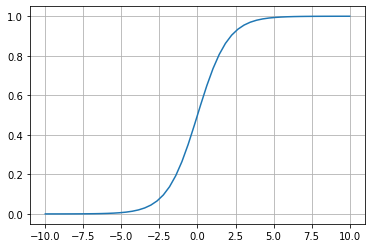

In [17]:
def sigmoid(value):
    a = np.exp(-value)
    return 1.0/ (1.0 + a)

for x in [
   -np.inf,
    0,
    1,
    np.inf
]:
    print(f"sigmoid({x}) = {sigmoid(x)}")

x = np.linspace(-10, 10)

plt.plot(x, sigmoid(x))
plt.grid(True)
plt.show()

To sum it up, in case of binary classification:
$$
\hat{p}(y=1 | x) = \sigma(w^Tx + b)
$$

What about the loss function which can train such a model?

We'll use a logarithmic loss function which quite nicely captures an intuition, that we want the predictions datapoints which should be predicted as $0$ as close to $0$ as possible, and, analogically, predictions which should be $1$, as close to $1$ as possible:

$$ L = \frac{-1}{n}\Big(\sum_{i=0}^n y^{(i)}\log{f(x^{(i)})} + (1-y^{(i)})\log{(1-f(x^{(i)}))} \Big)$$

This function is called **Binary Cross-Entropy**

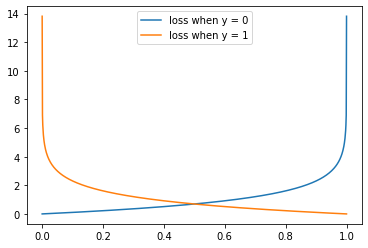

In [18]:
x = np.linspace(1e-6, 1 - (1e-6), 1000)

plt.plot(x, -np.log(1 - x), label="loss when y = 0")
plt.plot(x, -np.log(x), label="loss when y = 1")
plt.legend()
plt.show()

### Task for you: implement the binary cross-entropy function.

In [19]:
def binary_cross_entropy(x, y, w, b) -> float:
    #print("x.shape = ",np.shape(x))
    #print("y.shape = ",np.shape(y))
    #print("w.shape = ",np.shape(w))
    #print("b.shape = ",np.shape(b))
    N = np.shape(y)[0]
    z = np.matmul(x,w).reshape(-1)
    z = z+b
    sig = sigmoid(z)
    #print("x.shape = ",np.shape(x))
    #print("y.shape = ",np.shape(y))
    #print("w.shape = ",np.shape(w))
    #print("b.shape = ",np.shape(b))
    return -(np.sum(np.multiply(y,sig) + np.multiply(1-y,1-sig)))/N
    """
    All arguments are numpy arrays with shapes:
        x: [N, F]
        y: [N]
        w: [F, 1]
        b: [1]

    Returns:
        The value of binary cross-entropy (a single number).
    """
    ...

In [20]:
w = np.random.rand(30,1)
b = np.random.rand(1)

In [21]:
binary_cross_entropy(X_train,y_train,w,b)

-0.1722806074019793

In order to train the parameters $w, b$ of our model, we need to calculate the gradients of loss with regard to those parameters:

$$ \frac{\partial L}{\partial w} \text{ and } \frac{\partial L}{\partial b} $$


### Task for you: implement the function which calculates $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$:

In [22]:
def calculate_gradients(x, y, w, b) -> Tuple[np.ndarray, np.ndarray]:
    #print("x.shape = ",np.shape(x))
    #print("y.shape = ",np.shape(y))
    #print("w.shape = ",np.shape(w))
    #print("b.shape = ",np.shape(b))
    z = np.matmul(x,w).reshape(-1)
    z=z+b
    sig = sigmoid(z)
    mult1 = np.multiply(y,sig)
    dw1 = np.matmul(mult1,x)
    mult2 = np.multiply(y-1,sig)
    dw2 = np.matmul(mult2,x)
    db1 = np.sum(np.multiply(y,1-sig))
    db2 = np.sum(np.multiply(y-1,sig))
    #print(np.shape(dw1),np.shape(dw2))
    #print(np.shape(db1),np.shape(db2))
    return (dw1+dw2).reshape(np.shape(dw1)[0],-1),(db1+db2).reshape(-1)
    """
    All arguments are numpy arrays with shapes:
        x: [N, F]
        y: [N]
        w: [F, 1]
        b: [1]

    Returns:
        The gradients of loss L with regard to `w` and `b`. Their shapes should be identical to the shapes of `w` and `b`, respectively.
    """
    ...

In [23]:
dw ,db = calculate_gradients(X_train,y_train,w,b)

print(np.shape(dw), np.shape(db))

(30, 1) (1,)


With the gradient calculation implemented, we should be able to train our model with the **Gradient Descent** method.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


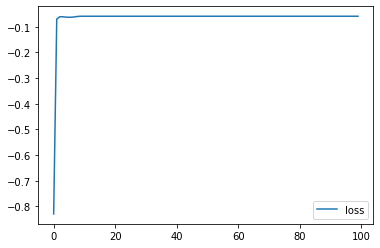

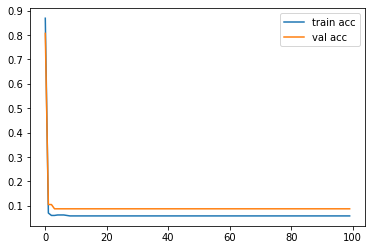

In [24]:
w = np.random.randn(30, 1) 
b = np.random.randn(1)
# how should we initialize w and b?

lr = 1e-1
# how big should be the learning rate?

history = []

for epoch in range(100):
    
    y_pred_train = sigmoid(np.matmul(X_train,w)+b)
    y_pred_train = (y_pred_train > 0.5).astype(int)
    train_accuracy = (y_pred_train.reshape(-1) == y_train).mean()
    
    y_pred_val = sigmoid(np.matmul(X_val,w)+b)
    y_pred_val = (y_pred_val > 0.5).astype(int)
    val_accuracy = (y_pred_val.reshape(-1) == y_val).mean()
    
    l_train = binary_cross_entropy(X_train, y_train, w=w, b=b)
    dw, db = calculate_gradients(X_train, y_train, w=w, b=b)

    w = w - (dw*lr)
    b = b - (db*lr)
    
    elem = dict(epoch=epoch, loss=l_train, train_accuracy=train_accuracy, val_accuracy=val_accuracy)
    history.append(elem)



plt.plot([h["epoch"] for h in history], [h["loss"] for h in history], label="loss")
plt.legend()
plt.show()

plt.plot([h["epoch"] for h in history], [h["train_accuracy"] for h in history], label="train acc")
plt.plot([h["epoch"] for h in history], [h["val_accuracy"] for h in history], label="val acc")
plt.legend()
plt.show()

## 3. Logistic regression with PyTorch automatic differentiation / loss / optimization tools

In [25]:
from torch.optim import SGD
from torch import nn
import torch

### Task for you: initialize a logistic regression PyTorch model and train it

In [26]:
model = nn.Sequential(
    nn.Linear(30,1),
    nn.Sigmoid(),
)
opt = SGD(model.parameters(), lr=1e-1)
loss_fn = nn.BCELoss()

print({
    name: p.shape
    for (name, p) in model.named_parameters()
})

{'0.weight': torch.Size([1, 30]), '0.bias': torch.Size([1])}


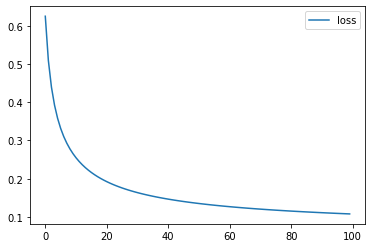

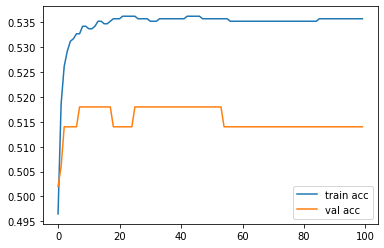

In [27]:
history = []

for epoch in range(100):
    opt.zero_grad()
    
    ### YOUR CODE HERE ###
    y_pred_train = model(torch.from_numpy(X_train).float())
    y_pred_val = model(torch.from_numpy(X_val).float())
    
    # calculate loss
    l_train = loss_fn(y_pred_train.reshape(-1), torch.from_numpy(y_train).float())
    # calculate gradients with respect to l_train
    l_train.backward()
    # perform the optimization step with the optimizer
    opt.step()
    #######################
    
    train_accuracy = ((y_pred_train.detach().numpy() > 0.5) == y_train).mean()
    val_accuracy = ((y_pred_val.detach().numpy() > 0.5) == y_val).mean()

    elem = dict(epoch=epoch, loss=l_train.item(), train_accuracy=train_accuracy, val_accuracy=val_accuracy)
    history.append(elem)
    


    
plt.plot([h["epoch"] for h in history], [h["loss"] for h in history], label="loss")
plt.legend()
plt.show()

plt.plot([h["epoch"] for h in history], [h["train_accuracy"] for h in history], label="train acc")
plt.plot([h["epoch"] for h in history], [h["val_accuracy"] for h in history], label="val acc")
plt.legend()
plt.show()

## 4. FashionMNIST: a bigger task

Let's now train a neural net on a more challenging, multi-label FashionMNIST task.

In [28]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms as tv
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

### Task: load the dataset and visualize some examples along with their classes
* what is the shape of a single example from the dataset?

In [29]:
ds = FashionMNIST('./data', train=True, target_transform=None, download=True, transform=tv.ToTensor()) # transform the data from PIL image to a tensor
ds_test = FashionMNIST('./data', train=False, target_transform=None, download=True, transform=tv.ToTensor()) # transform the data from PIL image to a tensor

In [30]:
batch_size=64

train_dl = DataLoader(ds, batch_size, shuffle=True)
valid_dl = DataLoader(ds_test, batch_size, shuffle=True)

### Task: implement and train a neural network with two linear layers and ReLU activation between them

In [95]:
class FashionNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # initialize the layers of the network
        # what is the size of the input? 28x28
        # what is the output size?       10
        self.simplenet = nn.Sequential(
            nn.Linear(28*28,80),
            nn.ReLU(),
            nn.Linear(80,10),
        )
        
    def forward(self, x):
        return self.simplenet(x)
        

In [96]:
net = FashionNN() # actually initialize the net
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters()) 

In [97]:
def to_one_hot_vector(num_class, label):
    b = torch.zeros((label.shape[0], num_class))
    b[torch.arange(label.shape[0]), label] = 1
    return b

In [98]:
y_mod = to_one_hot_vector(10,y_train)

In [ ]:
number_of_epochs = 10

for i in range(number_of_epochs):
    train_loss = 0
    for iteration, (X_train, y_train) in enumerate(train_dl):
        # perform optimization on the train set and calculate the total train loss
        y_train_pred = net(X_train.reshape(X_train.shape[0],-1))
        y_train_mod = to_one_hot_vector(10,y_train)
        train_loss = loss_fn(y_train_pred,y_train_mod)
        train_loss.backward()
        opt.step()
        
        
    val_loss = 0
    y_predicted = []
    y_true = []

    with torch.no_grad():
        for iteration, (X_val, y_val) in enumerate(valid_dl):
            # perform predictions on the validation set and gather them to calculate accuracy
            y_val = to_one_hot_vector(10,y_val)
            y_pred = net(X_val.reshape(X_val.shape[0],-1))
            loss = loss_fn(y_pred, y_val)
            val_loss += loss.item()
            y_pred = y_pred.argmax(dim=1)
            y_true.extend(y_val.numpy())
            y_predicted.extend(y_pred.numpy())
    
    #print(y_true.)
    #val_acc = accuracy_score(y_true, y_predicted)
    print(f'#Epoch: {i}, train loss: {train_loss}, val loss: {val_loss}') #val_acc: {val_acc}')
    

#Epoch: 0, train loss: 1.638819694519043, val loss: 234.82943868637085
#Epoch: 1, train loss: 1.4634674787521362, val loss: 239.19990473985672
#Epoch: 2, train loss: 1.2105817794799805, val loss: 258.8637844324112
#Epoch: 3, train loss: 1.186480164527893, val loss: 249.25495636463165
#Epoch: 4, train loss: 1.4335289001464844, val loss: 269.9572012424469
#Epoch: 5, train loss: 1.5350505113601685, val loss: 304.12625765800476
#Epoch: 6, train loss: 1.4897046089172363, val loss: 319.95444643497467
#Epoch: 7, train loss: 1.7724961042404175, val loss: 286.80704152584076
#Epoch: 8, train loss: 1.3556526899337769, val loss: 354.2677645087242
